
# Reconstruction of the diffusion signal with Correlation Tensor MRI (CTI)

Correlation Tensor MRI (CTI) is a method that uses double diffusion
encoding data to resolve sources of kurtosis. As the Q-space
Trajectory Imaging method
(see `sphx_glr_examples_built_reconstruction_reconst_qti.py`)
[NetoHe2020], CTI aims to resolve different sources of non-Gaussian diffusion.
However, in addition to the kurtosis sources associated with
diffusion variance across compartments (``K_aniso`` and ``K_iso``, which
are related to microscopic anisotropy and the variance of the mean
diffusivities of compartments, respectively), CTI also measures ``K_micro``.
This quantifies non-Gaussian diffusion effects that deviate from the multiple
Gaussian component tissue representation, such as restricted diffusion,
exchange, and structural disorder in compartments like cross-sectional
variance [NovelloL2022] [AlvesR2022].

As the long mixing time regime, the CorrelationTensorModel expresses the diffusion-weighted signal as:

$$ \log E_{\Delta}(q_1, q_2) = \left(q_{1i}q_{1j} + q_{2i}q_{2j}\right) \Delta D_{ij}  +\frac{1}{6} \left( q_{1i}q_{1j}q_{1k}q_{1l} + q_{2i}q_{2j}q_{2k}q_{2l} \right) \Delta^2 D^2 W_{ijkl} +  q_{1i}q_{1j}q_{2k}q_{2l}\Delta^2C_{ijkl} + O(q^6) $$

where: $\Delta D_{ij}$ is the total diffusion
tensor (DT), $W_{ijkl}$ is the total kurtosis tensor
(KT), $D$ is the mean diffusivity, and $C_{ijkl}$ is the covariance tensor.

In the following example we show how to fit the correlation tensor model on a
real life dataset and how to estimate correlation tensor based statistics.

First, we'll import all relevant modules.

In [1]:
import matplotlib.pyplot as plt

import dipy.reconst.cti as cti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.io.image import load_nifti
from dipy.data import get_fnames

For CTI analysis, data must be acquired using double diffusion encoding,
taking into account different pairs of b-values and gradient directions
between the two diffusion epochs, as discussed by Henriques et al. in Magn
Reson Med 2021 [NetoHe2021]._
To run CTI we need to have separate b-value and b-vector files for each DDE
diffusion epoch. In this tutorial, a sample DDE dataset and respective
b-value and b-vector files for the two epochs are fetched. If you want to
process your own DDE data compatible with CTI, you will have to change the
below lines of code to add the paths of your data.
The users should also ensure that the data is formatted correctly for the
CTI analysis they are performing.



In [2]:
fdata, fbvals1, fbvecs1, fbvals2, fbvecs2, fmask = get_fnames('cti_rat1')
data, affine = load_nifti(fdata)
bvals1, bvecs1 = read_bvals_bvecs(fbvals1, fbvecs1)
bvals2, bvecs2 = read_bvals_bvecs(fbvals2, fbvecs2)

In this example, the function load_nifti is used to load the CTI data saved
in filefdata and returns the data as a nibabel Nifti1Image object along with
the affine transformation. The b-values and b-vectors for two different
gradient tables are loaded from ``bvals1.bval`` and ``bvec1.bvec``, and
``bvals2.bval`` and ``bvec2.bvec``, respectively, using the
``read_bvals_bvecs`` function. For CTI reconstruction in DIPY, we need to
define the b-values and b-vectors for each diffusion epoch in separate
gradient tables, as done in the above line of code.



In [3]:
gtab1 = gradient_table(bvals1, bvecs1)
gtab2 = gradient_table(bvals2, bvecs2)

Before fitting the data, we perform some data pre-processing. We first
compute a brain mask to avoid unnecessary calculations on the background
of the image.



In [4]:
mask, mask_affine = load_nifti(fmask)

Now that we've loaded the data and generated the two gradient tables we can
go forward with CTI fitting. For this, the CTI model is first defined for
GradientTable objects gtab1 and gtab2 by instantiating the
CorrelationTensorModel object in the following way:



In [5]:
ctimodel = cti.CorrelationTensorModel(gtab1, gtab2)

To fit the data using the defined model object, we call the fit function of
this object.



In [6]:
ctifit = ctimodel.fit(data, mask=mask)

100%|████████████████████████████████████████████████████████████████████████████| 7516/7516.0 [03:13<00:00, 38.77it/s]


The fit method for the CTI model produces a CorrelationTensorFit object,
which contains the attributes of both the DKI and DTI models. Given that CTI
is a built upon DKI, which itself extends the DTI model, the
CorrelationTensorFit instance captures a comprehensive set of parameters and
attributes from these underlying models.

For instance, the CTI model inherently estimates all DTI and DKI statistics,
such as mean, axial, and radial diffusivities (MD, AD, RD) as well as the
mean, axial, and radial kurtosis (MK, AK, RK).
To better illustrate the extraction of main DTI/DKI parameters using the CTI
model, consider the following lines of code:



In [ ]:
AD = ctifit.ad
MD = ctifit.md
RD = ctifit.rd
MK = ctifit.mk()
AK = ctifit.ak()
RK = ctifit.rk()

However, in addition to these metrics, CTI also provides unique sources of
information, not available in DTI and DKI. Below we draw a feature map of the
3 different sources of kurtosis which can exclusively be calculated from the
CTI model.



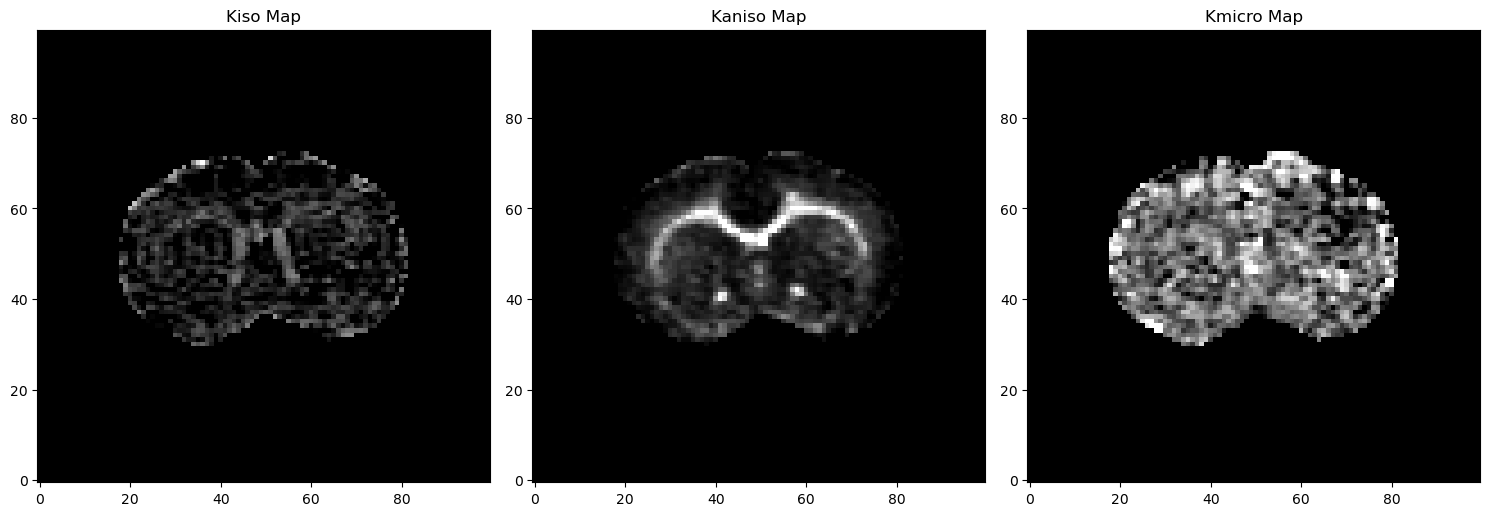

In [7]:
kiso_map = ctifit.K_iso
kaniso_map = ctifit.K_aniso
kmicro_map = ctifit.K_micro

slice_idx = 0
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

axarr[0].imshow(kiso_map[:, :, slice_idx], cmap='gray',
                origin='lower', vmin=0, vmax=1)
axarr[0].set_title('Kiso Map')

axarr[1].imshow(kaniso_map[:, :, slice_idx], cmap='gray',
                origin='lower', vmin=0, vmax=1)
axarr[1].set_title('Kaniso Map')

axarr[2].imshow(kmicro_map[:, :, slice_idx], cmap='gray',
                origin='lower', vmin=0, vmax=1)
axarr[2].set_title('Kmicro Map')

plt.tight_layout()
plt.show()

## References
[NetoHe2020] Henriques, R.N., Jespersen, S.N., Shemesh, N., 2020.
    Correlation tensor magnetic resonance imaging. Neuroimage 211.
    doi: 10.1016/j.neuroimage.2020.116605
    
[NovelloL2022] Novello, L., Henriques, R.N., Ianus, A., Feiweier, T.,
    Shemesh, N., Jovicich, J. 2022.
    In vivo Correlation Tensor MRI reveals microscopic kurtosis in the human
    brain on a clinical 3T scanner. Neuroimage 254: 119137
    doi: 10.1016/j.neuroimage.2022.119137
    
[AlvesR2022] Alves, R., Henriques, R.N., Kerkelä, L., Chavarrías C.,
Jespersen, S.N., Shemesh, N.
    2022. Correlation Tensor MRI deciphers underlying kurtosis sources in
    stroke, Neuroimage 247: 118833. doi: 10.1016/j.neuroimage.2021.118833
    
[NetHe2021] Henriques, R.N., Jespersen, S.N., Shemesh, N., 2021.
Evidence for microscopic kurtosis in neural tissue revealed by correlation
tensor MRI. Magn. Reson. Med. 1-20. doi: 10.1002/mrm.28938